# Sheet 5
Oliver Sange, Sam Rouppe van der Voort, Elias Huber

In [43]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## 2 Logistic regression: an LLM lie detector

Download the data from https://heibox.uni-heidelberg.de/f/38bd3f2a9b7944248cc2/   
Unzip it and place the lie_detection folder in the folder named `data` to get the following structure:
"data/lie_detection/datasets" and "data/lie_detection/acts".

This is how you can load a dataset of LLM activations. Use a new Datamanager if you want to have a new dataset. Use the same data manager if you want to combine datasets.

In [44]:
from lie_detection_utils import DataManager

path_to_datasets = "data/lie_detection/datasets"
path_to_acts = "data/lie_detection/acts"

# check if the datasets and activations are available
assert os.path.exists(path_to_datasets), "The path to the datasets does not exist."
assert os.path.exists(path_to_acts), "The path to the activations does not exist."

# these are the different datasets containing true and false factual statements about different topics
dataset_names = ["cities", "neg_cities", "sp_en_trans", "neg_sp_en_trans"]
dataset_name = dataset_names[0] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example

# the dataloader automatically loads the training data for us
dm = DataManager()
dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')
print(acts_train.shape, labels_train.shape)

torch.Size([1196, 4096]) torch.Size([1196])


In [45]:
# have a look at the statements that were fed to the LLM to produce the activations:
df = pd.read_csv(f"{path_to_datasets}/{dataset_name}.csv")
print(df.head(10))

                                        statement  label       city  \
0             The city of Krasnodar is in Russia.      1  Krasnodar   
1       The city of Krasnodar is in South Africa.      0  Krasnodar   
2                  The city of Lodz is in Poland.      1       Lodz   
3  The city of Lodz is in the Dominican Republic.      0       Lodz   
4            The city of Maracay is in Venezuela.      1    Maracay   
5                The city of Maracay is in China.      0    Maracay   
6              The city of Baku is in Azerbaijan.      1       Baku   
7                 The city of Baku is in Ukraine.      0       Baku   
8                  The city of Baoji is in China.      1      Baoji   
9              The city of Baoji is in Guatemala.      0      Baoji   

                  country correct_country  
0                  Russia          Russia  
1            South Africa          Russia  
2                  Poland          Poland  
3  the Dominican Republic          Poland 

### a)

In [46]:
from sklearn.linear_model import LogisticRegression

def train_log_reg(X,y,penalty=None,tol=1e-4): # training- data, labels    
    clf = LogisticRegression(penalty=penalty,tol=tol)
    clf.fit(X, y)

    return clf

def test_log_reg(clf, X, y): # test- data, labels
    #clf.predict(X)
    return clf.score(X,y)

In [47]:
for i in range(len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} performance :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_train, labels_train = dm.get('train') # train set
    acts_test, labels_test = dm.get('val')

    clf = train_log_reg(acts_train, labels_train)
    score_clf = test_log_reg(clf,acts_test, labels_test)
    print(f"score: {score_clf}")

cities performance :
score: 1.0
neg_cities performance :
score: 1.0
sp_en_trans performance :
score: 1.0
neg_sp_en_trans performance :
score: 1.0


The true and flase statements are linearly seperable since we get, perfect or near perfect score without regularization.

### b)

In [48]:
# train on cities w. and wo. regularization: 
dm = DataManager()
dm.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')

cities_clf = train_log_reg(acts_train, labels_train)
cities_clf_regularization = train_log_reg(acts_train, labels_train,penalty='l2')

In [49]:
print("Cities classifier performance on out of distribution test sets:")
for i in range(1,len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')

    score_cities_clf = test_log_reg(cities_clf,acts_test, labels_test)
    print(f"score unregularized: {score_cities_clf}")
    score_cities_clf_reg = test_log_reg(cities_clf_regularization,acts_test, labels_test)
    print(f"score regularized: {score_cities_clf_reg}")

Cities classifier performance on out of distribution test sets:
neg_cities :
score unregularized: 0.5833333333333334
score regularized: 0.5833333333333334
sp_en_trans :
score unregularized: 0.9436619718309859
score regularized: 0.971830985915493
neg_sp_en_trans :
score unregularized: 0.5070422535211268
score regularized: 0.5070422535211268


We see that the model does generalize to different true or flase statements, but not to negating true or flase questions.

### c)

In [50]:
import torch as t

# loading both data sets
dm = DataManager()
dm.add_dataset("cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train, labels_train = dm.get('train') # train set
acts_test, labels_test = dm.get('val')

dm = DataManager()
dm.add_dataset("neg_cities", "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
acts_train_neg, labels_train_neg = dm.get('train') # train set
acts_test_neg, labels_test_neg = dm.get('val')

# adding the data sets together:
train_data = t.cat((acts_train, acts_train_neg), dim=0)
train_labels = t.cat((labels_train, labels_train_neg), dim=0)
test_data = t.cat((acts_test, acts_test_neg), dim=0)
test_labels = t.cat((labels_test, labels_test_neg), dim=0)

# shuffeling data and train data
indices_tr = t.randperm(len(train_labels))
indices_te = t.randperm(len(test_labels))

train_data = train_data[indices_tr]
train_labels = train_labels[indices_tr]
test_data = train_data[indices_te]
test_labels = train_labels[indices_te]

In [51]:
cities_cities_neg_clf = train_log_reg(train_data, train_labels)
cities_cities_neg_clf_regularization = train_log_reg(train_data, train_labels,penalty='l2')

In [52]:
print("Cities and negation citites classifier performance on out of distribution test sets:")
for i in range(2,len(dataset_names)):
    dataset_name = dataset_names[i] # choose some dataset from the above datasets, index "0" loads the "cities" dataset for example
    print(f"{dataset_name} :")
    # the dataloader automatically loads the training data for us
    dm = DataManager()
    dm.add_dataset(dataset_name, "Llama3", "8B", "chat", layer=12, split=0.8, center=False,
                    device='cpu', path_to_datasets=path_to_datasets, path_to_acts=path_to_acts)
    acts_test, labels_test = dm.get('val')

    score_cities_cities_neg_clf = test_log_reg(cities_cities_neg_clf,acts_test, labels_test)
    print(f"score unregularized: {score_cities_cities_neg_clf}")
    score_cities_cities_neg_reg = test_log_reg(cities_clf_regularization,acts_test, labels_test)
    print(f"score regularized: {score_cities_cities_neg_reg}")

Cities and negation citites classifier performance on out of distribution test sets:
sp_en_trans :
score unregularized: 1.0
score regularized: 0.9859154929577465
neg_sp_en_trans :
score unregularized: 0.971830985915493
score regularized: 0.5352112676056338


It seems like we can train a logistic regression model for predicting both negating and non negating true false questions, and that it also seems like it generalizes well. Here the unregularized model performed better.

## 3 Log-sum-exp and soft(arg)max
### (b)

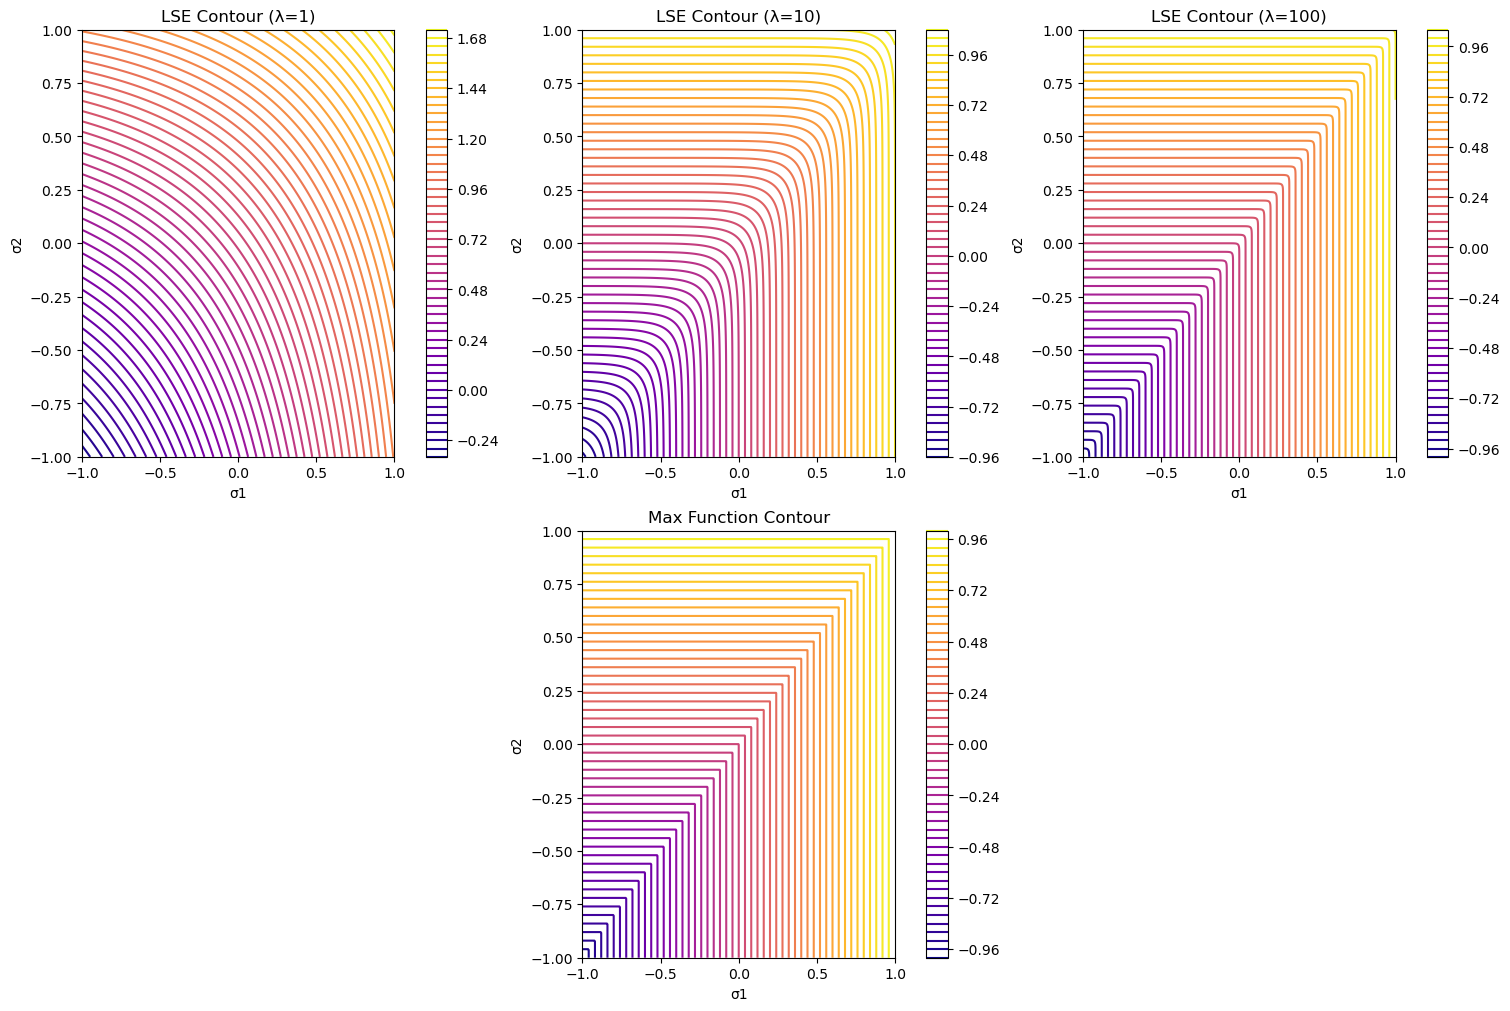

In [53]:
import numpy as np
import matplotlib.pyplot as plt

# Define the LSE function
def lse(sigma1, sigma2, lambd):
    return (1 / lambd) * np.log(np.exp(lambd * sigma1) + np.exp(lambd * sigma2))

# Define the max function
def max_func(sigma1, sigma2):
    return np.maximum(sigma1, sigma2)

# Generate a grid of sigma1 and sigma2 values
sigma1 = np.linspace(-1, 1, 500)
sigma2 = np.linspace(-1, 1, 500)
sigma1_grid, sigma2_grid = np.meshgrid(sigma1, sigma2)

# Compute the max function values
max_values = max_func(sigma1_grid, sigma2_grid)

# Compute LSE for different values of lambda
lambdas = [1, 10, 100]
lse_values = {l: lse(sigma1_grid, sigma2_grid, l) for l in lambdas}

# Plot the contours
fig, axes = plt.subplots(2, len(lambdas), figsize=(15, 10), constrained_layout=True)

# Plot LSE contours
for i, l in enumerate(lambdas):
    cs = axes[0, i].contour(sigma1_grid, sigma2_grid, lse_values[l], levels=50, cmap='plasma')
    axes[0, i].set_title(f"LSE Contour (λ={l})")
    axes[0, i].set_xlabel("σ1")
    axes[0, i].set_ylabel("σ2")
    fig.colorbar(cs, ax=axes[0, i])

# Plot max function contours
cs = axes[1, 1].contour(sigma1_grid, sigma2_grid, max_values, levels=50, cmap='plasma')
axes[1, 1].set_title("Max Function Contour")
axes[1, 1].set_xlabel("σ1")
axes[1, 1].set_ylabel("σ2")
fig.colorbar(cs, ax=axes[1, 1])

# Clear unnecessary axes in second row
axes[1, 0].axis('off')
axes[1, 2].axis('off')

plt.show()


We observe that for high lambda the sofargmax converges to the argmax contour.

### (c)

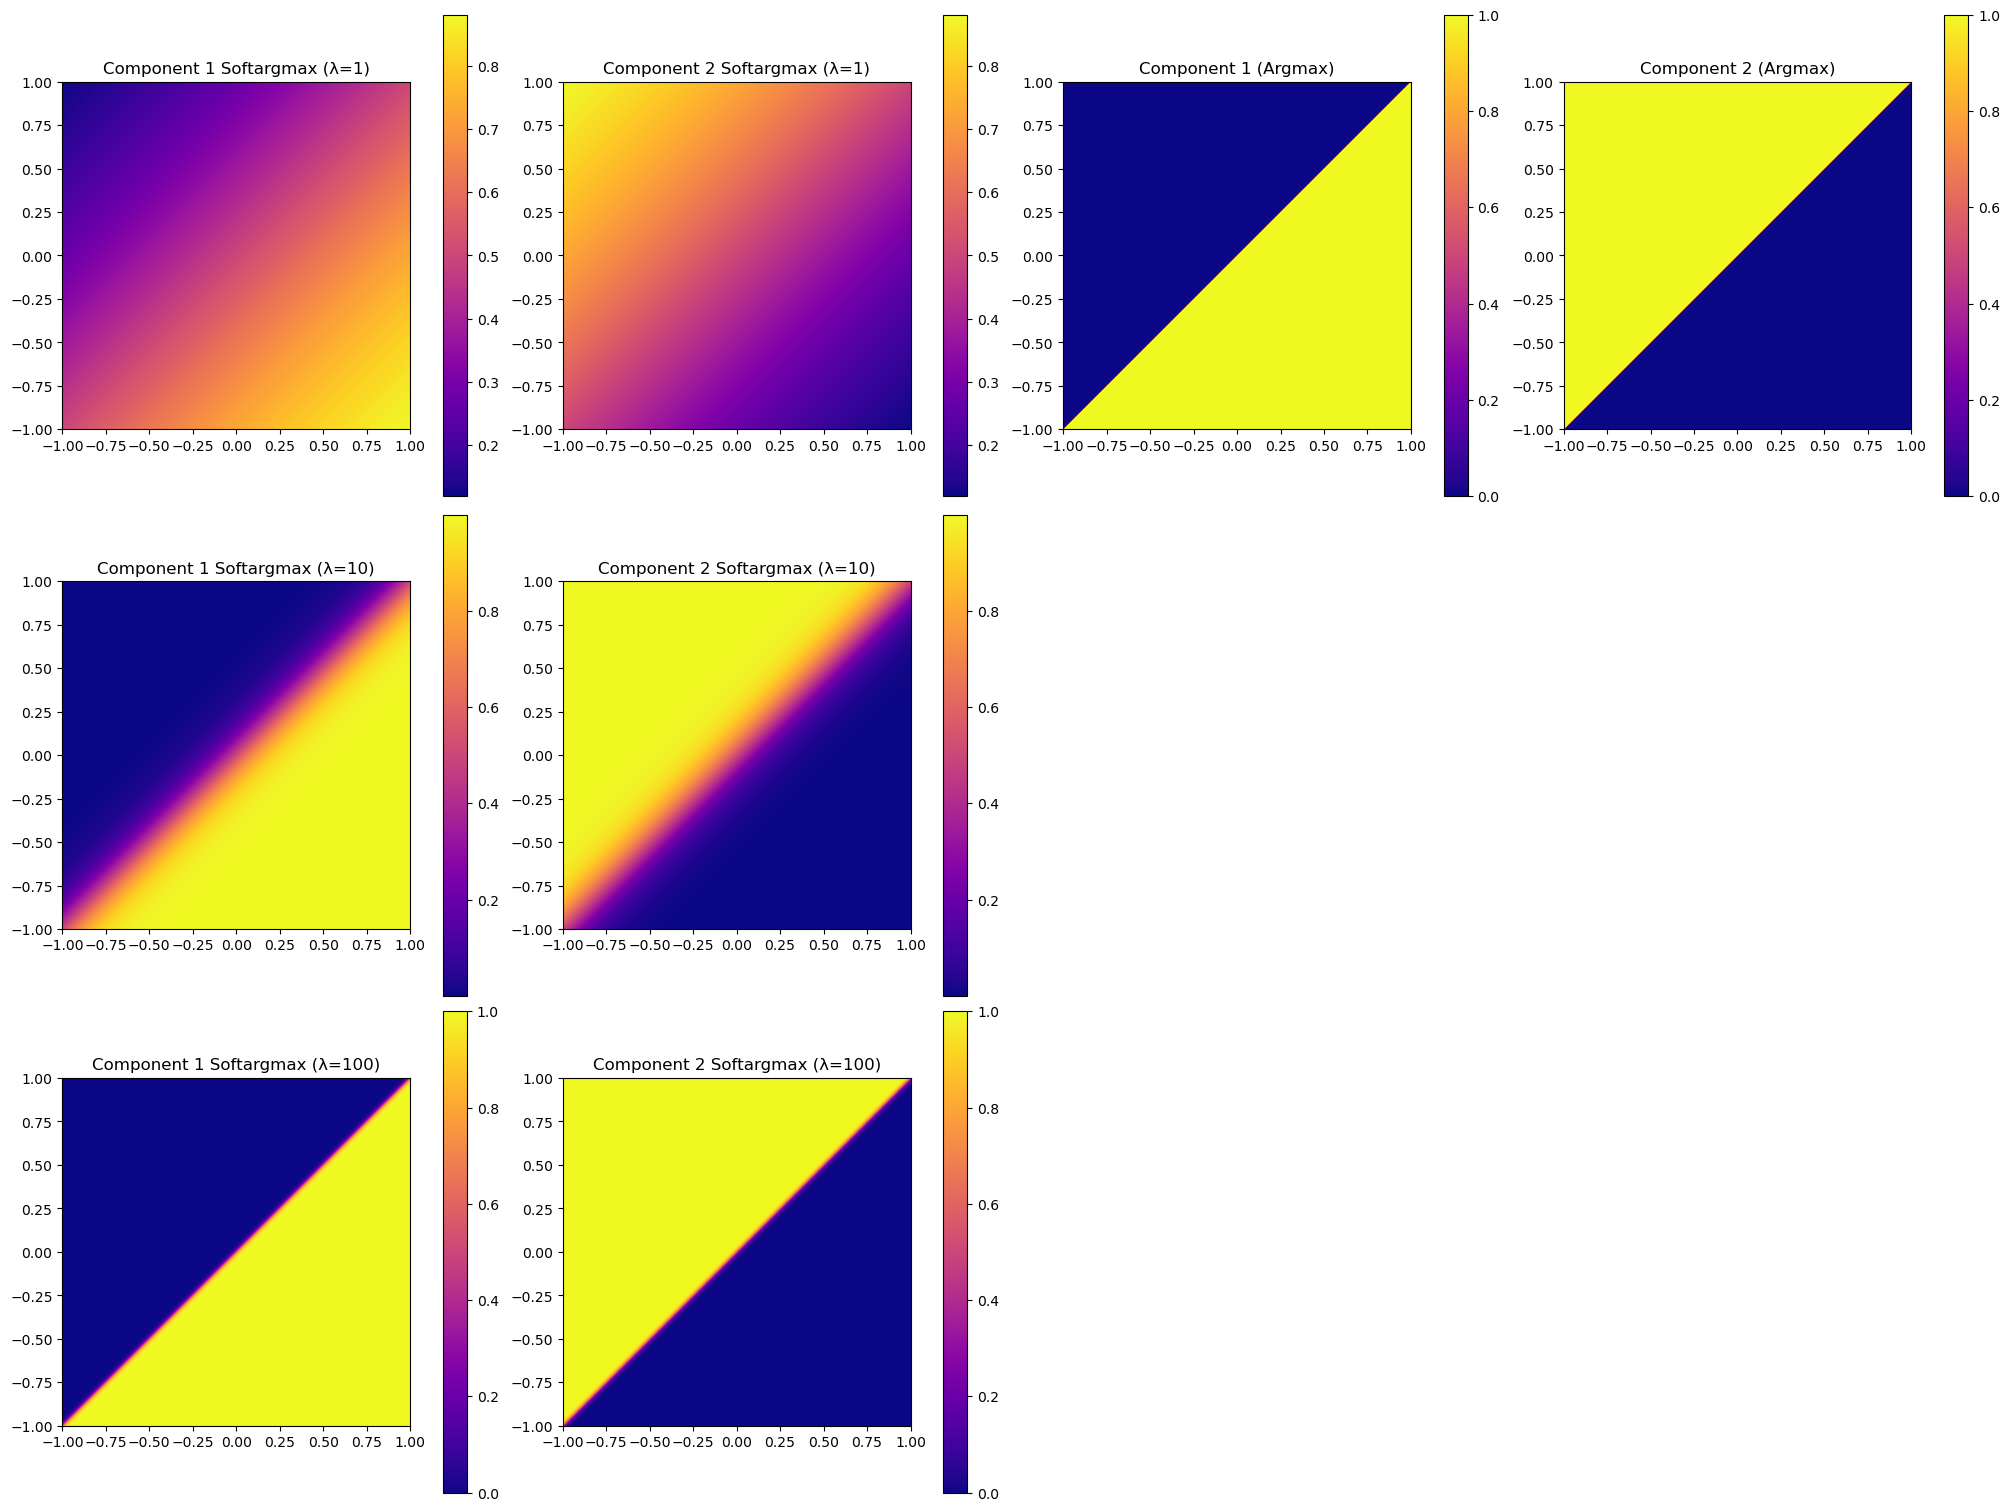

In [54]:

# Define the softmax components
def softargmax_components(sigma1, sigma2, lambd):
    exp1 = np.exp(lambd * sigma1)
    exp2 = np.exp(lambd * sigma2)
    total = exp1 + exp2
    return exp1 / total, exp2 / total

# Define the one-hot components for argmax
def onehot_argmax_components(sigma1, sigma2):
    mask1 = sigma1 > sigma2  # First component of the one-hot vector
    mask2 = ~mask1           # Second component of the one-hot vector (opposite of mask1)
    return mask1.astype(float), mask2.astype(float)

# Generate a grid of sigma1 and sigma2 values
sigma1 = np.linspace(-1, 1, 500)
sigma2 = np.linspace(-1, 1, 500)
sigma1_grid, sigma2_grid = np.meshgrid(sigma1, sigma2)

# Compute softargmax and one-hot components
lambdas = [1, 10, 100]
softargmax_results = {l: softargmax_components(sigma1_grid, sigma2_grid, l) for l in lambdas}
onehot_results = onehot_argmax_components(sigma1_grid, sigma2_grid)

# Plot the results
fig, axes = plt.subplots(len(lambdas), 4, figsize=(20, 15), constrained_layout=True)

for i, l in enumerate(lambdas):
    # Softargmax components
    comp1, comp2 = softargmax_results[l]
    im1 = axes[i, 0].imshow(comp1, extent=[-1, 1, -1, 1], origin='lower', cmap='plasma')
    im2 = axes[i, 1].imshow(comp2, extent=[-1, 1, -1, 1], origin='lower', cmap='plasma')
    axes[i, 0].set_title(f"Component 1 Softargmax (λ={l})")
    axes[i, 1].set_title(f"Component 2 Softargmax (λ={l})")
    fig.colorbar(im1, ax=axes[i, 0])
    fig.colorbar(im2, ax=axes[i, 1])

# One-hot components
comp1_onehot, comp2_onehot = onehot_results
im3 = axes[0, 2].imshow(comp1_onehot, extent=[-1, 1, -1, 1], origin='lower', cmap='plasma')
im4 = axes[0, 3].imshow(comp2_onehot, extent=[-1, 1, -1, 1], origin='lower', cmap='plasma')
axes[0, 2].set_title("Component 1 (Argmax)")
axes[0, 3].set_title("Component 2 (Argmax)")
fig.colorbar(im3, ax=axes[0, 2])
fig.colorbar(im4, ax=axes[0, 3])

# Clear unused axes in rows for one-hot (λ only affects softargmax)
for row in range(1, len(lambdas)):
    axes[row, 2].axis('off')
    axes[row, 3].axis('off')

plt.show()


## 4 Linear regions of MLPs
### a)

In [55]:
from torch import nn
import torch
import numpy as np

class MLP(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2,20),
      nn.ReLU(),
      nn.Linear(20,1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

mlp = MLP()
params = sum(p.numel() for p in mlp.parameters())
print(f"Number of parameters: {params}")
  

Number of parameters: 81


### b)

In [56]:
class nn_output_analyzer():
    def __init__(self,model,n_points,xrange):
        self.model = model
        self.num_points = n_points
        self.xrange = xrange


    def grid(self):
        # Create grid of points
        x = np.linspace(-self.xrange, self.xrange, self.num_points)
        y = np.linspace(-self.xrange, self.xrange, self.num_points)
        X, Y = np.meshgrid(x, y)
        
        # Prepare input for the model
        grid_points = np.column_stack((X.ravel(), Y.ravel()))
        grid_points_tensor = torch.FloatTensor(grid_points)
        
        # Evaluate model
        self.model.eval()
        with torch.no_grad():
            Z = self.model(grid_points_tensor).numpy().reshape(self.num_points, self.num_points)
        self.Z = Z
        # Create visualization
        plt.figure(figsize=(10, 8))
        plt.imshow(Z, extent=[-self.xrange, self.xrange, -self.xrange, self.xrange] ,
                   origin='lower', cmap='viridis')
        plt.colorbar(label='Model Output')
        plt.title(f'Neural Network Output (Range: [{-self.xrange}, {self.xrange}])')
        plt.xlabel('x')
        plt.ylabel('y')
        plt.show()

    def grad(self):
              # Compute spatial gradients
        dy, dx = np.gradient(self.Z)
        
        # Create subplots for visualization
        fig, (ax2, ax3) = plt.subplots(1, 2, figsize=(20, 6))
        
        # Plot x-component of gradient
        im2 = ax2.imshow(dx,  extent=[-self.xrange, self.xrange, -self.xrange, self.xrange], 
                         origin='lower', cmap='prism')
        ax2.set_title('Gradient (x-component)')
        ax2.set_xlabel('x')
        ax2.set_ylabel('y')
        plt.colorbar(im2, ax=ax2, label='∂f/∂x')
        
        # Plot y-component of gradient
        im3 = ax3.imshow(dy,  extent=[-self.xrange, self.xrange, -self.xrange, self.xrange], 
                         origin='lower', cmap='prism')
        ax3.set_title('Gradient (y-component)')
        ax3.set_xlabel('x')
        ax3.set_ylabel('y')
        plt.colorbar(im3, ax=ax3, label='∂f/∂y')
        
        plt.tight_layout()
        plt.show()

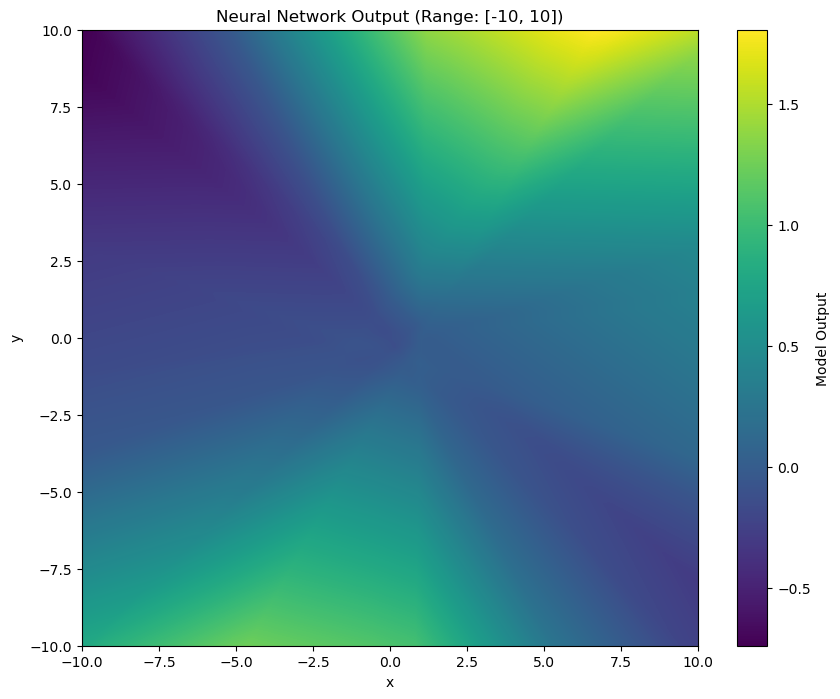

In [57]:
analyze = nn_output_analyzer(mlp,n_points=500,xrange=10)
analyze.grid()

### c)

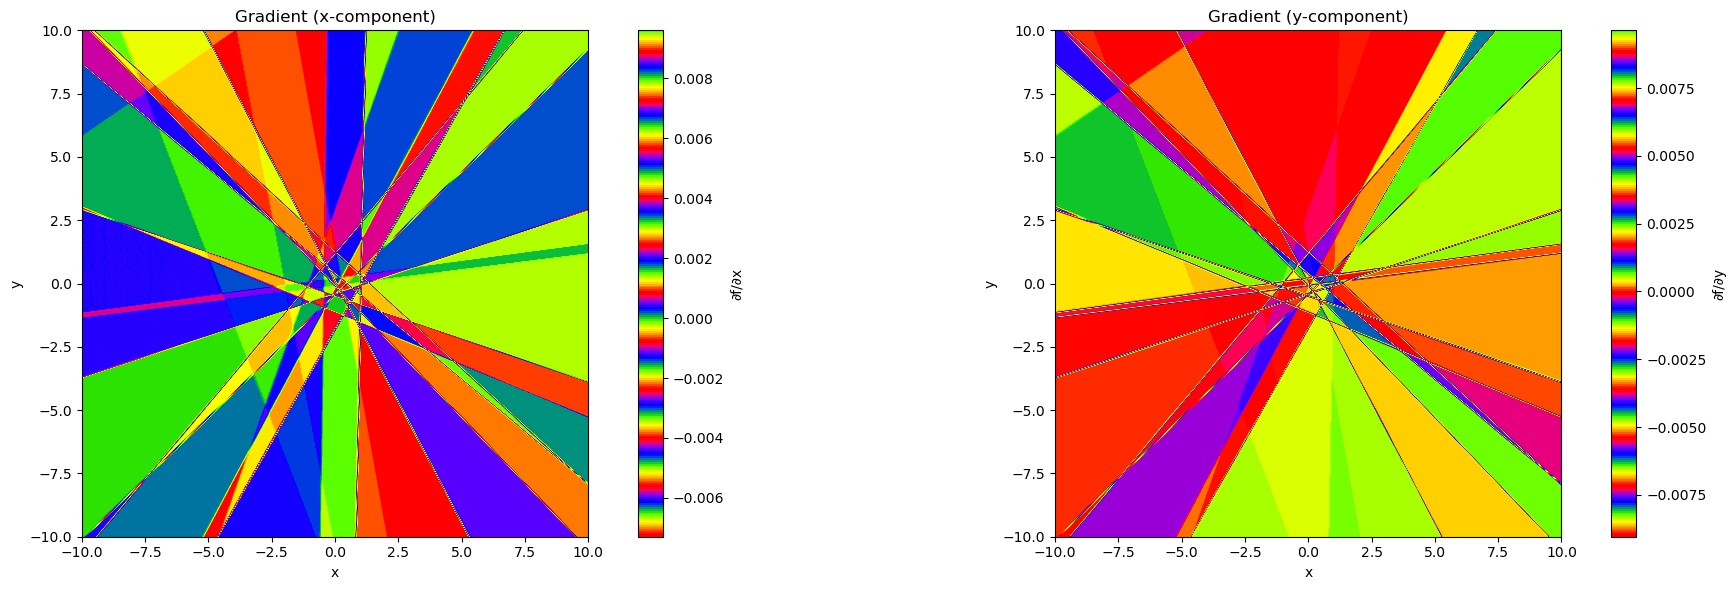

In [58]:
analyze.grad()

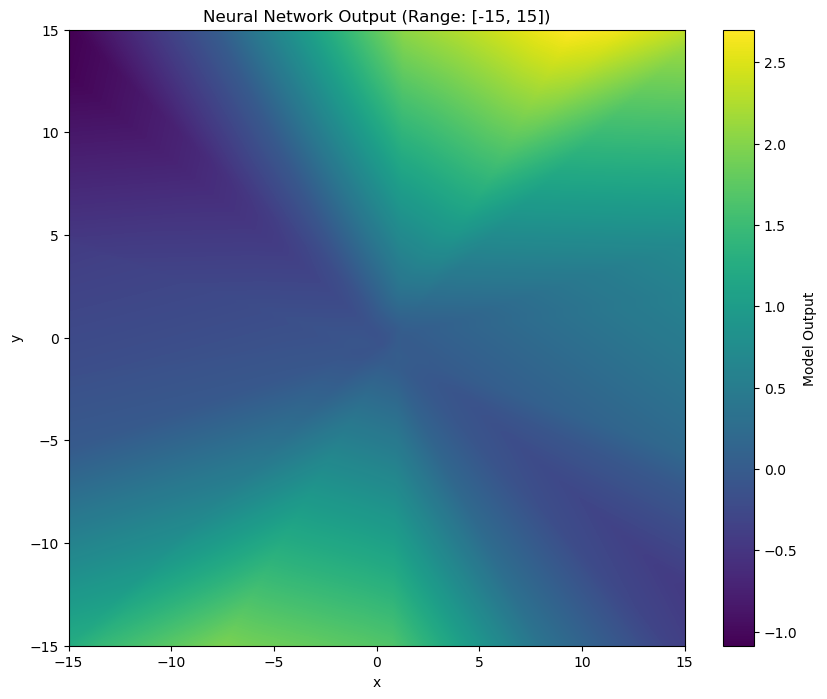

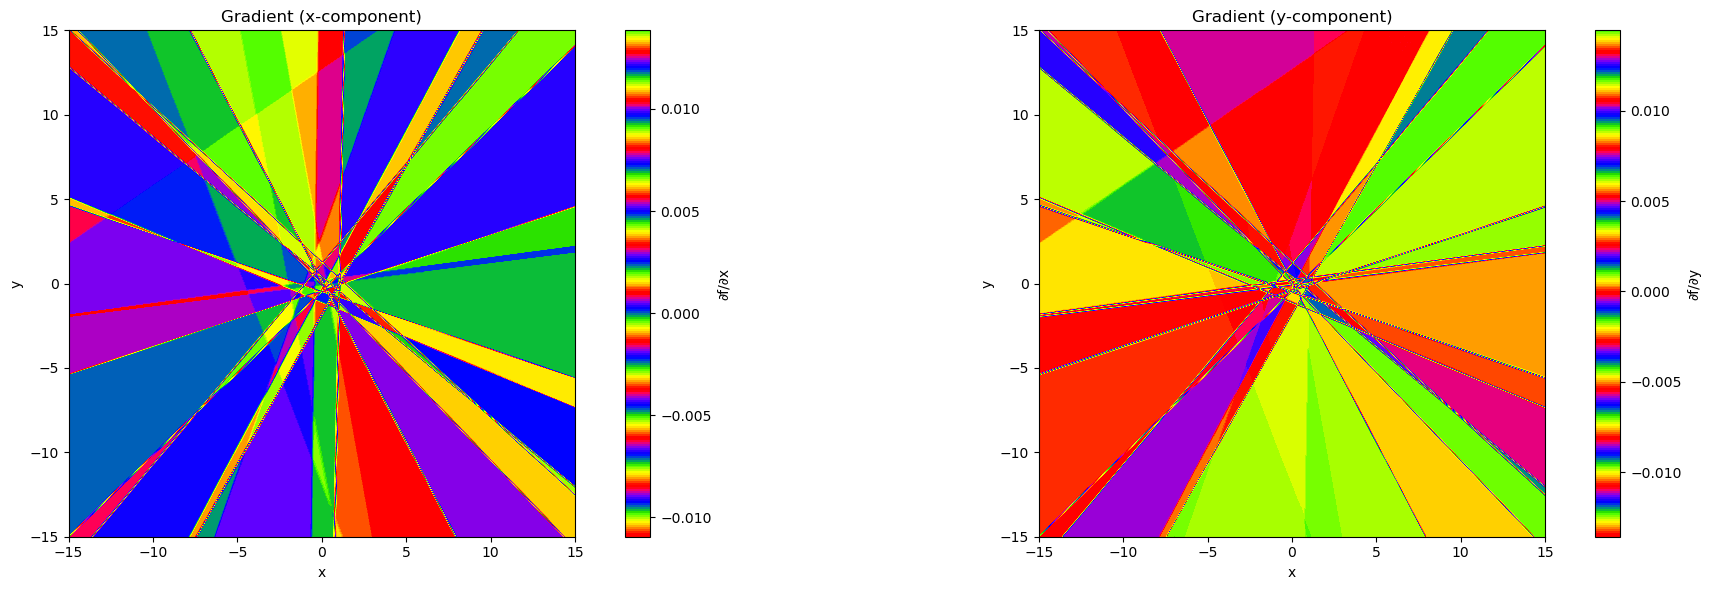

In [59]:
analyze = nn_output_analyzer(mlp,n_points=500,xrange=15)
analyze.grid()
analyze.grad()

We observe that we can capture the whole structure for a range of 15.

### d)

In [60]:
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

mlp2 = MLP2()
params = sum(p.numel() for p in mlp.parameters())
print(f"Number of parameters: {params}")
  

Number of parameters: 81


Number of parameters: 81


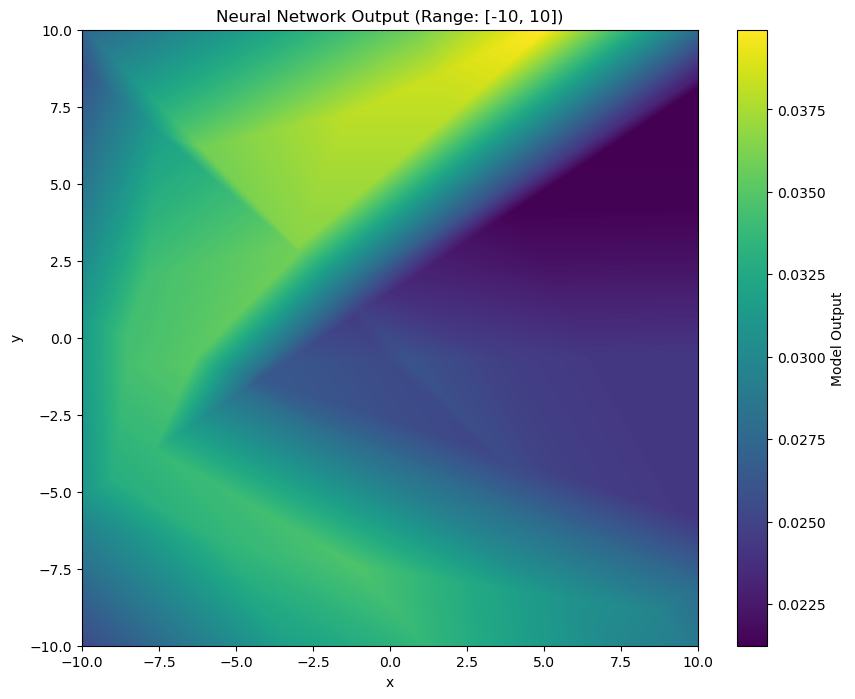

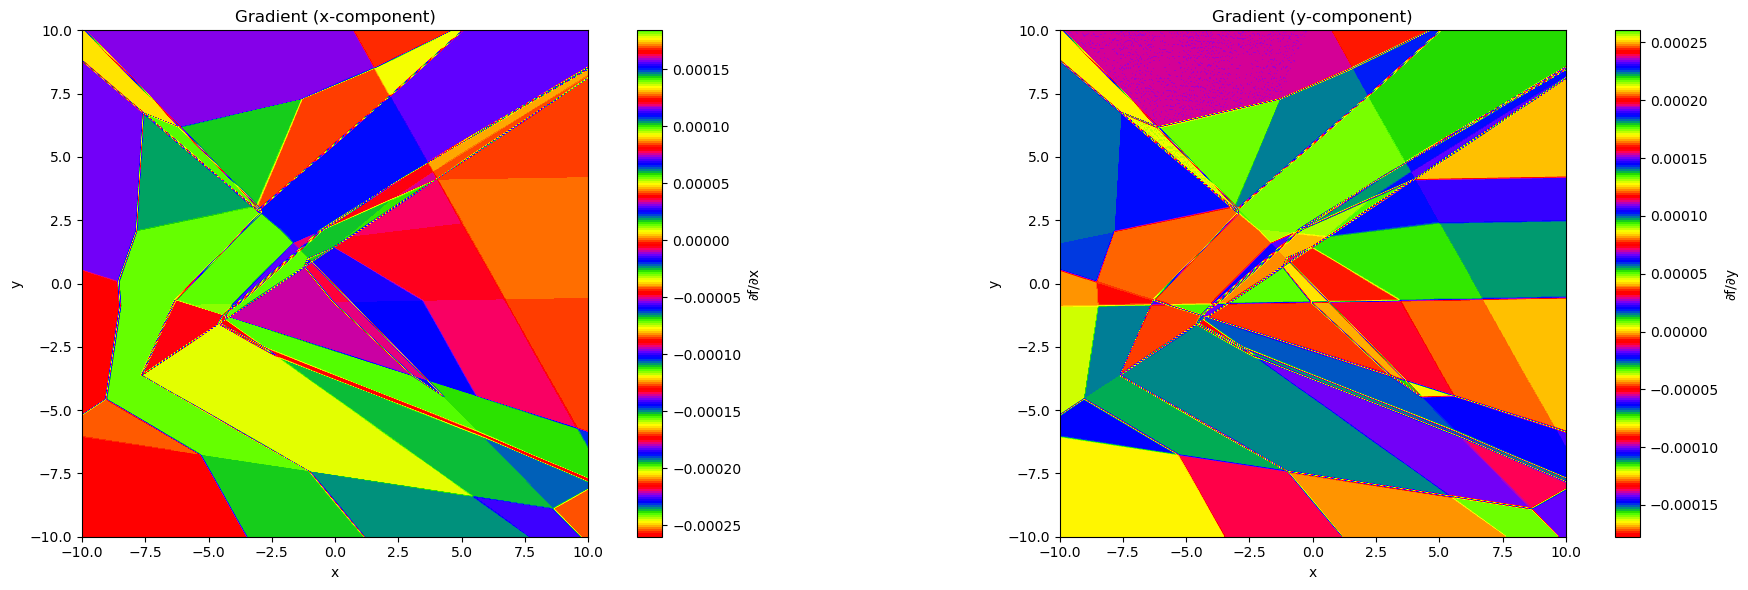

In [61]:
class MLP2(nn.Module):
  '''
    Multilayer Perceptron.
  '''
  def __init__(self):
    super().__init__()
    self.layers = nn.Sequential(
      nn.Linear(2,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,5),
      nn.ReLU(),
      nn.Linear(5,1)
    )


  def forward(self, x):
    '''Forward pass'''
    return self.layers(x)

mlp2 = MLP2()
params = sum(p.numel() for p in mlp.parameters())
print(f"Number of parameters: {params}")
  


analyze = nn_output_analyzer(mlp2,n_points=500,xrange = 10)
analyze.grid()
analyze.grad()

We observe that we can roughly observe the whole strucure for a range of 50.

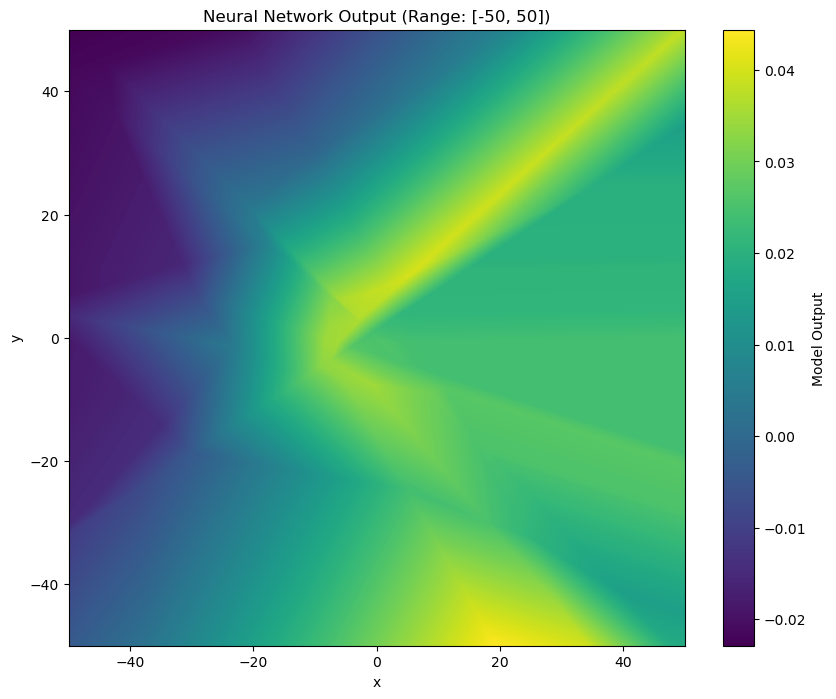

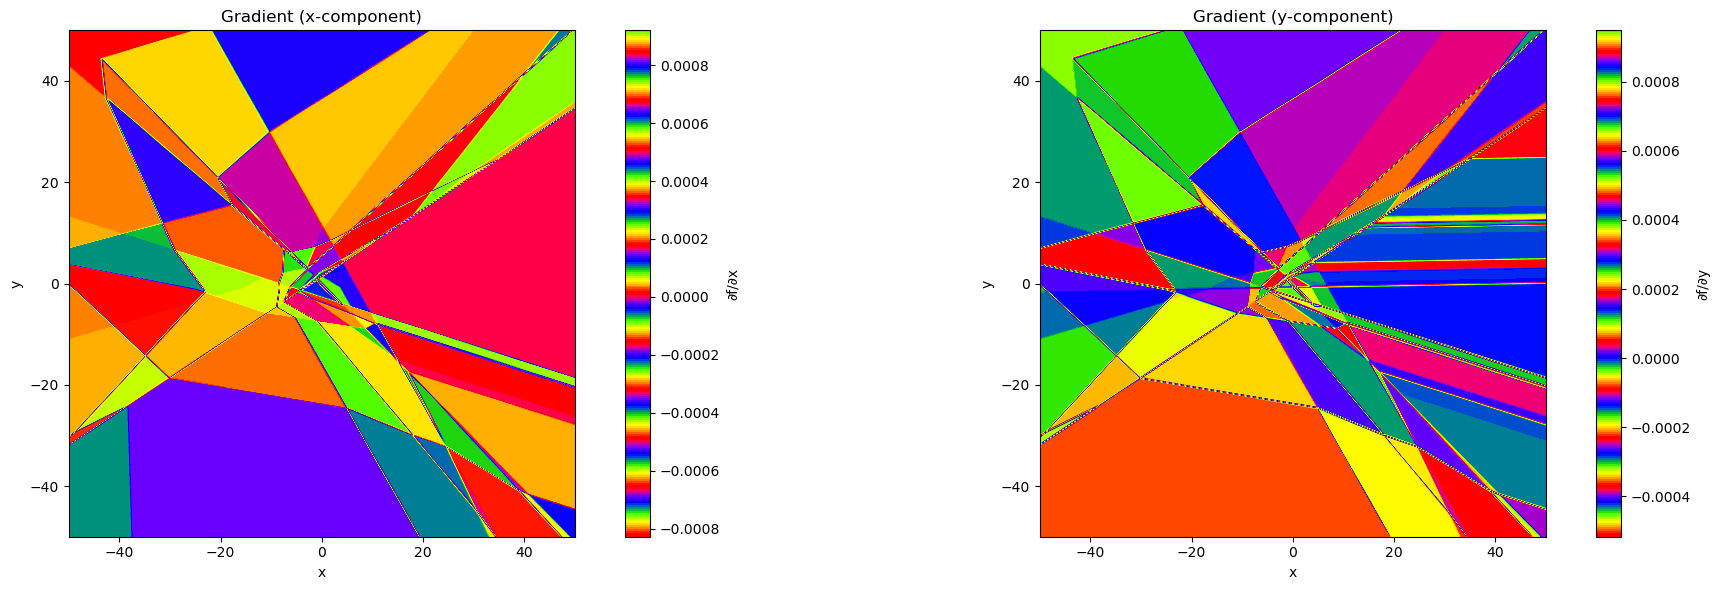

In [62]:
analyze = nn_output_analyzer(mlp2,n_points=500,xrange = 50)
analyze.grid()
analyze.grad()

We observe that we have to zoom further out for the deep network when comparing to the shalow one to capture the whole structure. We also estimate there to be more affine regions for the deeper network even though both networks have the same parameter count. This is due to the efficiency of depth.